# Discovery of repeated themes - Test with VMO

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import vmo.analysis as van
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
import os, itertools, csv, librosa, vmo, glob

%matplotlib inline

## Load JKUPDD dataset

In [3]:
file_path = '../JKUPDD-Aug2013/groundTruth/'
song_list = ['bachBWV889Fg', 'beethovenOp2No1Mvt3', 'chopinOp24No4', 'gibbonsSilverSwan1612', 'mozartK282Mvt2']
bpm_list = [84, 192, 138, 54, 120]
brange = [[1,110],[-1,555],[-1, 556],[1, 80],[-1,526]]
pattern_list = ['barlowAndMorgensternRevised', 'bruhn','schoenberg','sectionalRepetitions','tomCollins']

## Define Dataset Parser & Transpose Invariant Distance Function 

In [4]:
def get_occurence(f_path, pattern_list):
    f = itertools.chain.from_iterable([[_f+'/'+c+'/occurrences/csv/' for c in os.listdir(f_path+_f+'/') if not c.startswith('.')] 
                                        for _f in os.listdir(f_path) if (not _f.startswith('.') and _f in pattern_list)])
    f = list(f)
    occur = [[_c for _c in os.listdir(f_path+'/'+_f) if not _c.startswith('.')] for _f in f[:]]
    out = []
    for c,s in zip(occur, f):
        occ_list = []
        for _c in c:
            csv_file = open(f_path+s+_c,'r')
            cs = list(csv.reader(csv_file))
            region = [float(cs[0][0]),float(cs[-1][0])]
            occ_list.append(region)
        out.append(occ_list)
    return out

def array_rotate(a):
    _a = a
    for _i in range(1,a.size):
        _a = np.vstack((_a, np.roll(a,_i)))
    return _a
        
def trnspose_inv(a, b):
    d_vec = []
    a = np.array(a)
    a_mat = array_rotate(a)
    d = a_mat - np.array(b)
    d = np.sqrt((d*d).sum(axis=1))
    return d.min()


## Parse Dataset

In [5]:
audio_list = [{'audio':[file_path+song+'/polyphonic/audio/'+a for a in os.listdir(file_path+song+'/polyphonic/audio/') if a.endswith('wav')][0],
               'info':(song, bpm, beat_range),
               'pattern':get_occurence(file_path+song+'/polyphonic/repeatedPatterns/', pattern_list)} 
                for song, bpm, beat_range in zip(song_list, bpm_list, brange)]
    

## Chromagram and Beat Extraction

In [6]:
ind = 4 # Change index for different songs in the dataset (0~4)
audio_test = audio_list[ind]

In [7]:
y, sr = librosa.load(audio_test['audio'], sr = 11025)
fft_size = 8192
hop_size = 64
C = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_size)
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_size)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/librosa/filters.py:251: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


## Sub-Beat-Synchronous Chromagram

In [9]:
subbeats = []
for bs, be in zip(beats[:-1],beats[1:]):
    subbeats.extend(np.linspace(bs, be, num = 2, endpoint = False).astype('int').tolist())
subbeats.extend(np.linspace(beats[-1], C.shape[1], num = 2, endpoint = False).astype('int').tolist())
subbeats.append(C.shape[1])
C_sync = librosa.util.sync(C, subbeats, aggregate=np.median)
C_sync = librosa.feature.stack_memory(C_sync, n_steps=3)
feature = np.log(C_sync+np.finfo(float).eps)
feature = pre.normalize(feature)

## Create VMO 

In [10]:
chroma_frames = feature.transpose()
r = (0.0, 2.0, 0.01) 
ideal_v_inv = vmo.find_threshold(chroma_frames, r = r,flag = 'a', dim=chroma_frames.shape[1],
                                 dfunc = 'other', dfunc_handle = trnspose_inv)
oracle_inv= vmo.build_oracle(chroma_frames, flag = 'a', dim=chroma_frames.shape[1],
                            threshold = ideal_v_inv[0][1], 
                            feature = 'chroma', dfunc = 'other', dfunc_handle = trnspose_inv)

## Create Recurrence Plot with VMO

In [11]:
selfmat = van.create_selfsim(oracle_inv, method = 'rsfx')

## Gather Ground Truth from Dataset

In [19]:
ground = np.zeros((len(audio_test['pattern']), audio_test['info'][2][1]-audio_test['info'][2][0]))
len_list = []
for i,p in enumerate(audio_test['pattern']):
    for _p in p:
        start = _p[0] - audio_test['info'][2][0]
        end = _p[1] - audio_test['info'][2][0]
        len_list.append(end-start)
        ground[i][int(start):int(end)+1] = 1
min_len = 5

## Plots of Chromagram, Sub-Beat-Synchronous Chromagram, Recurrence Plot and Ground Truth of Repeated Themes

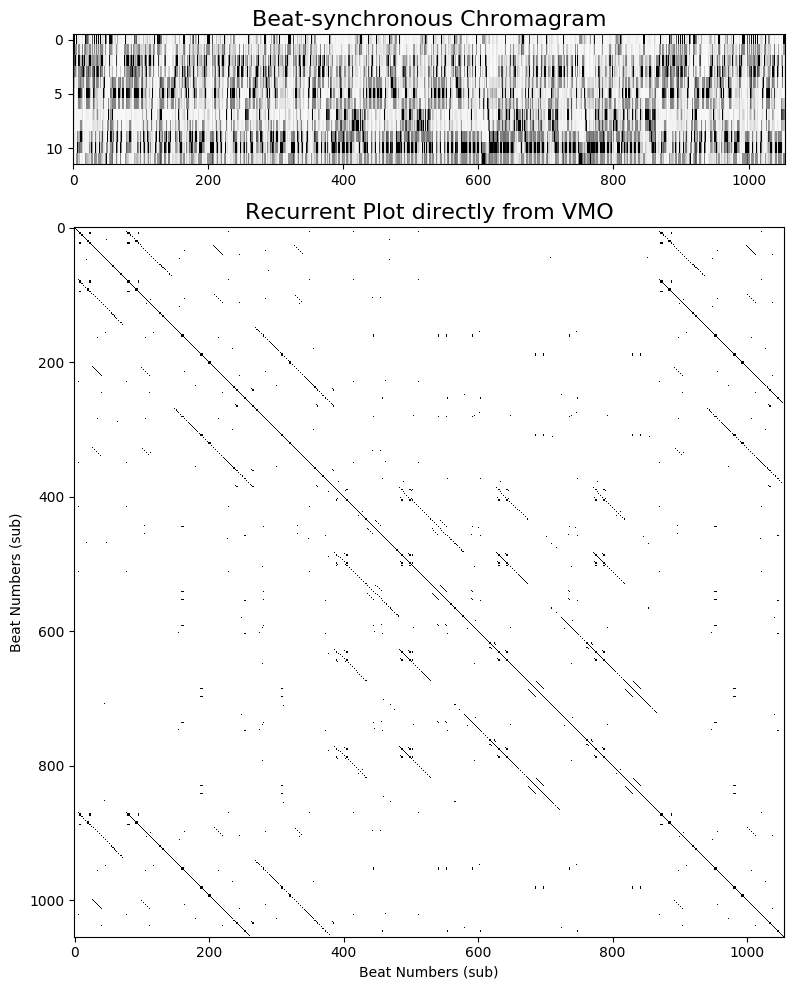

In [21]:
plt.figure(figsize=(8,10))

plt.subplot2grid((5,1),(0,0))
plt.imshow(C_sync, interpolation='nearest', aspect='auto',cmap = 'Greys')
plt.title('Beat-synchronous Chromagram', fontsize = 16)

plt.subplot2grid((5,1),(1,0), rowspan = 4)
plt.imshow(np.exp(selfmat), cmap = 'Greys', interpolation = 'nearest')
plt.title('Recurrent Plot directly from VMO', fontsize = 16)
plt.ylabel('Beat Numbers (sub)')
plt.xlabel('Beat Numbers (sub)')
plt.tight_layout()
# plt.savefig('/Users/cheng-iwang/Documents/GitHub/VMO_repeated_themes_discovery/supplementPlots/'+audio_test['info'][0]+'/chromagramAndRecurrencePlot.pdf')

## Check IR Profile

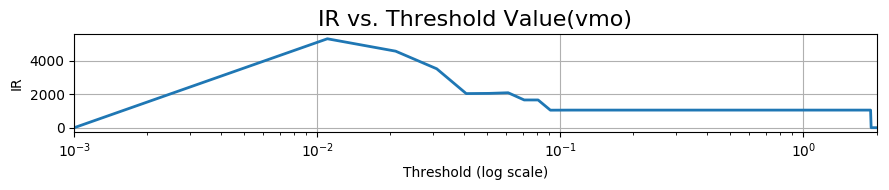

In [27]:
x_v = np.array([i[1] for i in ideal_v_inv[1]])+0.001
y_v = [i[0] for i in ideal_v_inv[1]]
fig = plt.figure(figsize=(9,2))
ax = fig.add_subplot(1,1,1)
ax.plot(x_v, y_v, linewidth = 2)
plt.title('IR vs. Threshold Value(vmo)', fontsize = 16)
plt.grid(b = 'on')
plt.xlabel('Threshold (log scale)')
plt.ylabel('IR')
plt.xlim(0.001,2)
ax.set_xscale('log')
plt.tight_layout()
# plt.savefig('/Users/cheng-iwang/Documents/GitHub/VMO_repeated_themes_discovery/supplementPlots/'+audio_test['info'][0]+'/irProfile.pdf')

## Extract Repeated Suffixes from VMO

In [23]:
pattern = van.find_repeated_patterns(oracle_inv, lower = min_len)
pattern_mat = np.zeros((len(pattern), oracle_inv.n_states-1))
for i,p in enumerate(pattern):
    length = p[1]
    for s in p[0]:
        pattern_mat[i][s-length:s-1] = 1

# pattern_plot = pattern_mat[[2,4,1,0,6,5,3],:]
pattern_plot = pattern_mat

## Plot Ground Truth and Found Repeated Suffixes

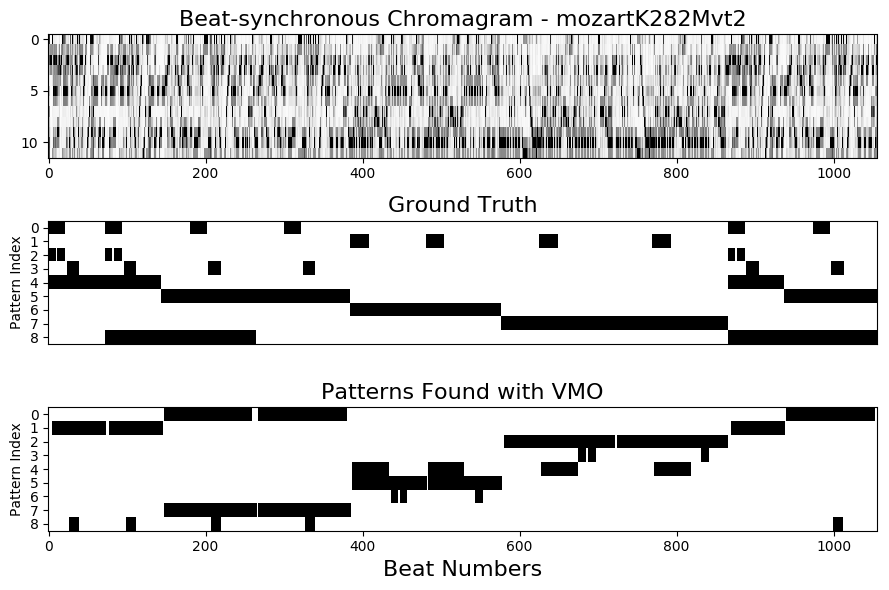

In [26]:
plt.figure(figsize = (9,6))
plt.subplot(311)
ax = plt.imshow(C_sync, interpolation='nearest', aspect='auto',cmap = 'Greys')
plt.title('Beat-synchronous Chromagram - '+ audio_test['info'][0], fontsize = 16)
plt.subplot(312)
plt.imshow(ground, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
plt.title('Ground Truth', fontsize = 16)
plt.ylabel('Pattern Index')
plt.yticks(np.arange(ground.shape[0]))
plt.xticks([])
# plt.yticks([])
# plt.xlabel('Beat Numbers')
plt.subplot(313)
# plt.imshow(pattern_mat, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
plt.imshow(pattern_plot, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
plt.title('Patterns Found with VMO',fontsize=16)
# plt.yticks([])
plt.yticks(np.arange(pattern_plot.shape[0]))
plt.ylabel('Pattern Index')
plt.xlabel('Beat Numbers',fontsize=16)
plt.tight_layout()
# plt.savefig('jkupdd_patterns.pdf')
# plt.savefig('/Users/cheng-iwang/Documents/GitHub/VMO_repeated_themes_discovery/supplementPlots/'+audio_test['info'][0]+'/jkupdd_patterns.pdf')